In [1]:
# Load required packages
library(dplyr,warn.conflicts=F)
library(stringr,warn.conflicts=F)
library(psych,warn.conflicts=F)
library(lplyr,warn.conflicts=F)
library(tidyr,warn.conflicts=F)

library(ggplot2,warn.conflicts=F)

In [2]:
# Final ranking of madness
data.teamtourneyranks <- readRDS('TeamTourneyRanking.rds')
# ranking mapping
data.tourneyranks <- read.csv('TourneyRanks.csv')# load ranking db
data.ranking <- readRDS('../datafiles_rds/MasseyOrdinals.rds')
# keep 2018, last day
data.ranking %>% 
    filter(Season==2018) %>%
    filter(RankingDayNum==max(RankingDayNum)) %>%
    select(-RankingDayNum) -> data.lastranking

In [3]:
# Keep only 68 tourney teams
data.lastranking %>%
    inner_join(data.teamtourneyranks,by=c('Season','TeamID')) %>% 
    group_by(Season,SystemName) %>% 
    summarise(n=n()) %>% 
    ungroup() %>% 
    filter(n==68) -> df.systems
data.lastranking %>%
    semi_join(df.systems,by=c('Season','SystemName')) -> df.ranking

#### Prepare 

In [4]:
data.matchups <- readRDS('../datafiles_rds/TourneyMatchups.rds')
data.matchups %>% 
    filter(Season==2018) -> data.matchups

In [5]:
df.ranking %>% 
    distinct(SystemName) %>%
    mutate(Season=2018) -> data.SystemName

In [6]:
data.matchups %>%
    inner_join(data.SystemName,by='Season') -> df.matchups

In [7]:
df.matchups %>%
    inner_join(df.ranking,by=c('Season','SystemName','TeamID.x'='TeamID')) %>%
    rename(Rank.x=OrdinalRank) %>%
    inner_join(df.ranking,by=c('Season','SystemName','TeamID.y'='TeamID')) %>%
    rename(Rank.y=OrdinalRank) -> df.matchups

In [8]:
Slope <- 3/(350/3)

In [9]:
df.matchups %>%
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rank.y-Rank.x,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(ID,SystemName,Pred,Prob) -> df.submit

#### Performance

In [10]:
data.truth <- readRDS('../datafiles_rds/TourneyTrueResults.rds')

In [11]:
df.submit %>%
    inner_join(data.truth,by='ID') -> df.results

In [32]:
df.results %>%
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) -> df.results
df.results %>%
    group_by(SystemName) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Accuracy=TC/N,LogLoss=-mean(LogLoss)) %>%
    ungroup() %>%
    select(SystemName,TC,FC,N,Accuracy,LogLoss) -> df.test.perf
df.test.perf %>% arrange(desc(Accuracy)) %>% head

SystemName,TC,FC,N,Accuracy,LogLoss
MAS,51,16,67,0.7611940,0.5670578
WOL,51,16,67,0.7611940,0.5741345
SGR,50,17,67,0.7462687,0.5649686
COL,49,18,67,0.7313433,0.5698548
DOL,49,18,67,0.7313433,0.5793139
RPI,49,18,67,0.7313433,0.5676642


#### Masters Predictors

In [13]:
df.results %>%
    group_by(ID) %>%
    summarise(CSS=sum(OK)) %>%
    arrange(CSS) -> toto

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


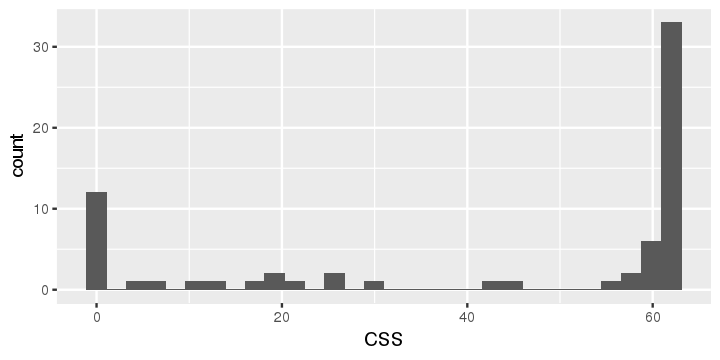

In [14]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(data=toto,aes(x=CSS)) + geom_histogram()

In [15]:
df.test.perf %>% arrange(desc(Accuracy)) %>% head

SystemName,TC,FC,N,Accuracy,LogLoss
MAS,51,16,67,0.7611940,0.5670578
WOL,51,16,67,0.7611940,0.5741345
SGR,50,17,67,0.7462687,0.5649686
COL,49,18,67,0.7313433,0.5698548
DOL,49,18,67,0.7313433,0.5793139
RPI,49,18,67,0.7313433,0.5676642


In [28]:
df.results %>%
    filter(SystemName %in% c('MAS','WOL')) %>%
    mutate(Delta=abs(Prob-0.5)) %>%
    group_by(ID) %>%
    mutate(Tot=sum(OK)) %>% 
    ungroup() %>% 
    filter(Tot==1)

ID,SystemName,Pred,Prob,Target,OK,LogLoss,Delta,Tot
2018_1382_1417,MAS,0,0.449,1,0,-0.8007324,0.051,1
2018_1382_1417,WOL,1,0.601,1,1,-0.5091603,0.101,1
2018_1260_1274,MAS,1,0.506,1,1,-0.6812186,0.006,1
2018_1260_1274,WOL,0,0.494,1,0,-0.7052198,0.006,1
2018_1120_1155,MAS,0,0.474,0,1,-0.6424541,0.026,1
2018_1120_1155,WOL,1,0.526,0,0,-0.7465480,0.026,1
2018_1344_1401,MAS,1,0.538,0,0,-0.7721904,0.038,1
2018_1344_1401,WOL,0,0.386,0,1,-0.4877604,0.114,1


In [29]:
df.results %>%
    filter(SystemName %in% c('MAS','WOL')) %>%
    mutate(Delta=abs(Prob-0.5)) %>%
    group_by(ID) %>%
    mutate(Tot=sum(OK), mDelta=mean(Delta)) %>% 
    mutate_which(Tot==1 & Delta==mDelta,Prob=0.5) %>%
    ungroup() %>%
    arrange(desc(Delta)) %>%
    group_by(ID) %>%
    slice(1:1) %>%
    ungroup() %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) -> df.masters

In [30]:
df.masters %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Accuracy=TC/N,LogLoss=-mean(LogLoss)) 

TC,N,FC,Accuracy,LogLoss
53,67,14,0.7910448,0.5592676


In [31]:
df.masters %>%
    mutate(Prob=case_when(Prob<0.5 ~ 0.21, Prob>0.5 ~ 0.79, TRUE ~ 0.5)) %>%
#    mutate(Prob=case_when(Prob>0.2 & Prob<0.5 ~ 0.2, Prob>0.5 & Prob<0.8 ~ 0.8, TRUE ~ 0.5)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Accuracy=TC/N,LogLoss=-mean(LogLoss)) 

TC,N,FC,Accuracy,LogLoss
53,67,14,0.7910448,0.5262269


#### Tri Master Predictors

In [33]:
df.test.perf %>% arrange(desc(Accuracy),LogLoss) %>% head

SystemName,TC,FC,N,Accuracy,LogLoss
MAS,51,16,67,0.7611940,0.5670578
WOL,51,16,67,0.7611940,0.5741345
SGR,50,17,67,0.7462687,0.5649686
RPI,49,18,67,0.7313433,0.5676642
COL,49,18,67,0.7313433,0.5698548
DOL,49,18,67,0.7313433,0.5793139


In [37]:
df.results %>%
    filter(SystemName %in% c('MAS','WOL','SGR')) %>%
    mutate(Delta=abs(Prob-0.5)) %>%
    mutate(W=ifelse(SystemName=='MAS',2,1)) %>%
    group_by(ID) %>%
    mutate(Tot=sum(W*OK)) %>% 
    ungroup() %>%
    group_by(Tot) %>%
    summarise(n=n())

Tot,n
0,39
1,3
2,9
3,12
4,138


In [38]:
df.results %>%
    filter(SystemName %in% c('MAS','WOL','SGR')) %>%
    mutate(Delta=abs(Prob-0.5)) %>%
    mutate(W=ifelse(SystemName=='MAS',2,1)) %>%
    group_by(ID) %>%
    mutate(Tot=sum(W*OK), mDelta=mean(Delta)) %>% 
    mutate_which(Tot>0 & Tot<4,Prob=0.5) %>%
    ungroup() %>%
    arrange(desc(Delta)) %>%
    group_by(ID) %>%
    slice(1:1) %>%
    ungroup() %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) -> df.masters

In [39]:
df.masters %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Accuracy=TC/N,LogLoss=-mean(LogLoss)) 

TC,N,FC,Accuracy,LogLoss
51,67,16,0.761194,0.5592519


### 2019

In [ ]:
# load ranking db
data.ranking <- read.csv('../2019/Prelim2019_MasseyOrdinals.csv',stringsAsFactors=F)
# keep 2019, last day
data.ranking %>% 
    filter(Season==2019) %>%
    filter(SystemName %in% c('MAS','WOL')) %>%
    filter(RankingDayNum==max(RankingDayNum)) %>%
    select(-RankingDayNum) -> data.lastranking

In [ ]:
data.madnessteams <- read.csv('../2019//NCAATourneySeeds.csv',stringsAsFactors=F)
data.madnessteams %>% 
    filter(Season==2019) %>%
    select(Season,TeamID) -> data.madnessteams

In [ ]:
data.madnessteams %>%
    full_join(data.madnessteams,by='Season') %>%
    filter(TeamID.x < TeamID.y) -> data.matchups 

In [ ]:
data.lastranking %>% 
    filter(SystemName %in% c('MAS','WOL')) -> df.ranking

In [ ]:
df.ranking %>% 
    distinct(SystemName) %>%
    mutate(Season=2019) -> data.SystemName

In [ ]:
data.matchups %>%
    inner_join(data.SystemName,by='Season') -> df.matchups

In [ ]:
df.matchups %>%
    inner_join(df.ranking,by=c('Season','SystemName','TeamID.x'='TeamID')) %>%
    rename(Rank.x=OrdinalRank) %>%
    inner_join(df.ranking,by=c('Season','SystemName','TeamID.y'='TeamID')) %>%
    rename(Rank.y=OrdinalRank) -> df.matchups

In [ ]:
Slope <- 3/(350/3)

In [ ]:
df.matchups %>%
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rank.y-Rank.x,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(ID,SystemName,Pred,Prob) -> df.submit

In [ ]:
df.submit %>% head

In [ ]:
df.submit %>%
    mutate(Delta=abs(Prob-0.5)) %>%
    group_by(ID) %>%
    mutate(Tot=sum(Pred), mDelta=mean(Delta)) %>% 
    mutate_which(Tot==1 & Delta==mDelta,Prob=0.5) %>%
    ungroup() %>%
    arrange(desc(Delta)) %>%
    group_by(ID) %>%
    slice(1:1) %>%
    ungroup() -> df.masters.2019

In [ ]:
df.masters.2019 %>%
    mutate(Prob=case_when(Prob<0.5 ~ 0.21, Prob>0.5 ~ 0.79, TRUE ~ 0.5)) -> df.masters.2019

In [ ]:
# save the best results for kaggle submission
df.masters.2019 %>% 
    select(ID,Pred=Prob) %>% 
    write.csv('../predictions_2019/RankingMasters.csv',quote=F,row.names=F)

In [ ]:
# save best model for mix
df.masters.2019 %>%
    saveRDS('../predictions_2019/RankingMasters.rds') 

In [36]:
df.results %>% count / 67

n
62
